Columns: ['UserID', 'SessionID', 'Timestamp', 'EventType', 'ProductID', 'Amount', 'Outcome']
EventType uniques (sample): EventType
page_view       10819
add_to_cart     10735
product_view    10696
logout          10685
purchase        10682
click           10632
login           10568
Name: count, dtype: int64
Rows with ProductID and mapped funnel event: 32113


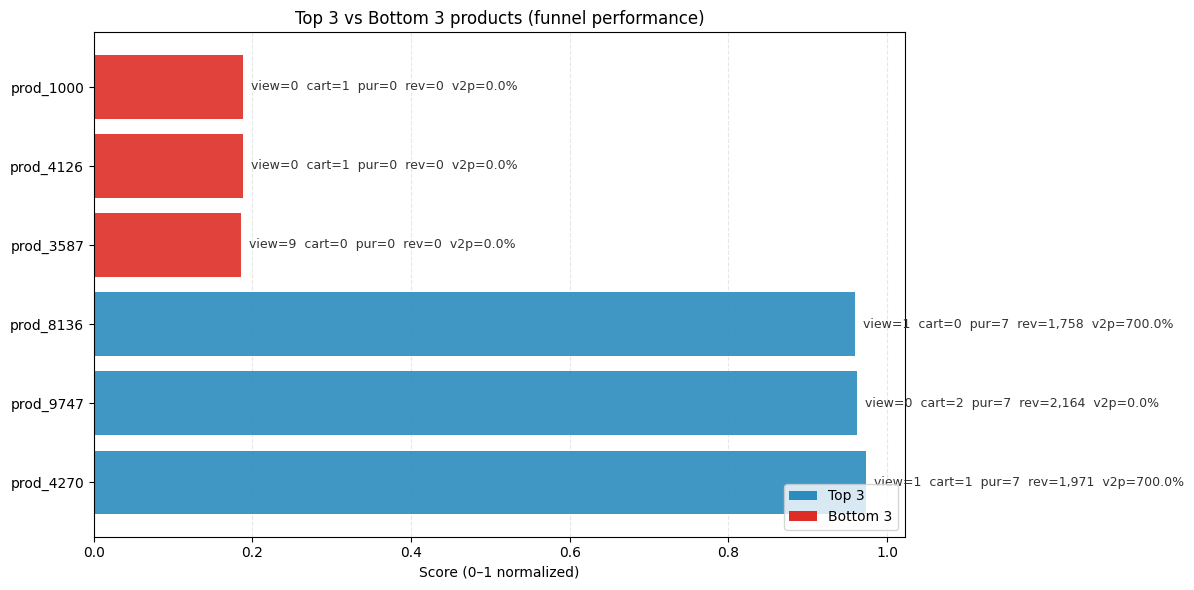

   ProductID     group  view  cart  purchase      revenue         aov  \
0  prod_4270     Top 3     1     1         7  1970.578638  281.511234   
1  prod_9747     Top 3     0     2         7  2163.821351  309.117336   
2  prod_8136     Top 3     1     0         7  1758.028100  251.146871   
3  prod_3587  Bottom 3     9     0         0     0.000000    0.000000   
4  prod_4126  Bottom 3     0     1         0     0.000000    0.000000   
5  prod_1000  Bottom 3     0     1         0     0.000000    0.000000   

   view_to_purchase     score  
0               7.0  0.974105  
1               0.0  0.962635  
2               7.0  0.959721  
3               0.0  0.185436  
4               0.0  0.188596  
5               0.0  0.188596  


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("ecommerce_clickstream_transactions.csv")

# --- quick sanity checks (keep these in the interview) ---
print("Columns:", df.columns.tolist())
print("EventType uniques (sample):", df["EventType"].astype(str).str.lower().str.strip().value_counts().head(15))

# --- normalize columns we rely on ---
df = df.copy()
df["EventType_norm"] = df["EventType"].astype(str).str.lower().str.strip()
df["ProductID"] = df["ProductID"].where(df["ProductID"].notna(), np.nan)

# --- map event names to a canonical funnel: view / cart / purchase ---
def map_event(e: str) -> str | None:
    # adapt these rules fast if your dataset uses different naming
    if any(k in e for k in ["view", "product_view", "pageview", "item_view", "view_item"]):
        return "view"
    if any(k in e for k in ["cart", "add_to_cart", "addtocart", "add to cart", "basket"]):
        return "cart"
    if any(k in e for k in ["purchase", "order", "transaction", "checkout_complete", "completed", "payment"]):
        return "purchase"
    return None

df["funnel_event"] = df["EventType_norm"].map(map_event)

dfp = df[df["ProductID"].notna() & df["funnel_event"].notna()].copy()

# If this prints 0, your ProductID or event mapping is the issue
print("Rows with ProductID and mapped funnel event:", len(dfp))

# --- counts per product per funnel step ---
funnel = (
    dfp.pivot_table(index="ProductID", columns="funnel_event", values="UserID", aggfunc="count", fill_value=0)
    .rename_axis(None, axis=1)
)

# --- revenue / AOV from purchase rows (Amount may be named differently in your CSV) ---
if "Amount" in dfp.columns:
    purch = dfp[dfp["funnel_event"] == "purchase"]
    funnel["revenue"] = purch.groupby("ProductID")["Amount"].sum().reindex(funnel.index).fillna(0)
    funnel["aov"]     = purch.groupby("ProductID")["Amount"].mean().reindex(funnel.index).fillna(0)
else:
    funnel["revenue"] = 0.0
    funnel["aov"] = 0.0

# --- conversion rates ---
views = funnel.get("view", 0).replace(0, np.nan)
carts = funnel.get("cart", 0).replace(0, np.nan)
funnel["view_to_cart"]     = (funnel.get("cart", 0) / views).fillna(0)
funnel["cart_to_purchase"] = (funnel.get("purchase", 0) / carts).fillna(0)
funnel["view_to_purchase"] = (funnel.get("purchase", 0) / views).fillna(0)

def minmax(s: pd.Series) -> pd.Series:
    s = s.astype(float)
    rng = s.max() - s.min()
    return (s - s.min()) / rng if rng != 0 else pd.Series(0.0, index=s.index)

# --- scoring ---
# Idea: use smoothed conversion rates so that "1 view, 7 purchases" doesn't dominate
# just because of tiny sample size. We shrink each product towards the global average.

# Global baselines
global_v2p = (funnel.get("purchase", 0).sum() / funnel.get("view", 0).replace(0, np.nan).sum())
global_c2p = (funnel.get("purchase", 0).sum() / funnel.get("cart", 0).replace(0, np.nan).sum())

# Simple Bayesian-style smoothing helper
def smoothed_rate(successes: pd.Series, trials: pd.Series, prior_rate: float, strength: float) -> pd.Series:
    successes = successes.astype(float)
    trials = trials.astype(float)
    # Posterior mean of Beta-Binomial with prior alpha=prior_rate*strength, beta=(1-prior_rate)*strength
    alpha = prior_rate * strength
    beta = (1 - prior_rate) * strength
    return (successes + alpha) / (trials + alpha + beta)

views_raw = funnel.get("view", 0).astype(float)
carts_raw = funnel.get("cart", 0).astype(float)
purch_raw = funnel.get("purchase", 0).astype(float)

# Smoothed conversion rates
funnel["v2p_smooth"] = smoothed_rate(purch_raw, views_raw.clip(lower=1.0), global_v2p, strength=20.0)
funnel["c2p_smooth"] = smoothed_rate(purch_raw, carts_raw.clip(lower=1.0), global_c2p, strength=20.0)

# Traffic proxy (to reward products with meaningful exposure)
traffic = views_raw + carts_raw + purch_raw

# Keep the original score for reference, and define an improved one
funnel["score_v1"] = (
    0.30 * minmax(np.log1p(funnel["revenue"])) +
    0.30 * minmax(funnel["view_to_purchase"]) +
    0.20 * minmax(funnel["cart_to_purchase"]) +
    0.20 * minmax(np.log1p(funnel.get("view", 0)))
)

# New score: smoothed conversion + revenue + volume
funnel["score"] = (
    0.40 * minmax(np.log1p(funnel["revenue"])) +
    0.30 * minmax(funnel["v2p_smooth"]) +
    0.15 * minmax(funnel["c2p_smooth"]) +
    0.15 * minmax(np.log1p(traffic))
)

# --- top/bottom 3 (guard: need at least 3 products) ---
funnel = funnel.sort_values("score", ascending=False)
top3 = funnel.head(3).copy()
bot3 = funnel.tail(3).sort_values("score", ascending=True).copy()

summary = pd.concat([top3.assign(group="Top 3"), bot3.assign(group="Bottom 3")]).reset_index()

# --- plot ---
order = pd.concat([
    summary[summary["group"] == "Top 3"].sort_values("score", ascending=False),
    summary[summary["group"] == "Bottom 3"].sort_values("score", ascending=True),
], ignore_index=True)

# Use horizontal bars, and color by group for quick scan
fig, ax = plt.subplots(figsize=(12, 6))
colors = order["group"].map({"Top 3": "#2b8cbe", "Bottom 3": "#de2d26"}).fillna("#636363")

ax.barh(order["ProductID"].astype(str), order["score"].values, color=colors, alpha=0.9)
ax.set_xlabel("Score (0–1 normalized)")
ax.set_title("Top 3 vs Bottom 3 products (funnel performance)")

# Add a light grid and tighten layout
ax.grid(axis="x", linestyle="--", alpha=0.3)
ax.set_axisbelow(True)

# Annotate each bar with key funnel stats
for i, r in order.iterrows():
    label = (
        f"view={int(r.get('view', 0))}  "
        f"cart={int(r.get('cart', 0))}  "
        f"pur={int(r.get('purchase', 0))}  "
        f"rev={float(r.get('revenue', 0)):,.0f}  "
        f"v2p={float(r.get('view_to_purchase', 0)):.1%}"
    )
    ax.text(
        r["score"] + 0.01,  # nudge to the right of the bar
        i,
        label,
        va="center",
        fontsize=9,
        color="#333333",
    )

# Add a simple legend for colors
from matplotlib.patches import Patch
legend_handles = [
    Patch(facecolor="#2b8cbe", label="Top 3"),
    Patch(facecolor="#de2d26", label="Bottom 3"),
]
ax.legend(handles=legend_handles, loc="lower right")

plt.tight_layout()
plt.show()

# table output (top/bottom only)
cols = ["ProductID","group","view","cart","purchase","revenue","aov","view_to_purchase","score"]
print(order[cols])